<a href="https://colab.research.google.com/github/noONE17o/data-mining-/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Cloab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Online Retail.xlsx')

print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [ ]:
import pandas as pd
import numpy as np

# Step 1: Load dataset and clean data
data = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Online Retail.xlsx")
data = data.dropna(subset=['CustomerID'])
data = data[data['Quantity'] > 0]

# Step 2: Feature Engineering
reference_date = data['InvoiceDate'].max()
customer_metrics = data.groupby('CustomerID').agg(
    MonetaryValue=('UnitPrice', lambda x: (x * data['Quantity']).sum()),
    Frequency=('InvoiceNo', 'nunique'),
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days)
).reset_index()

# Step 3: Format for clustering
customer_metrics = customer_metrics.rename(columns={'CustomerID': 'ID'})
formatted_data = customer_metrics[['ID', 'MonetaryValue', 'Frequency', 'Recency']]

# Step 4: Outlier Detection and Removal using Z-Score
# Calculate z-scores for MonetaryValue, Frequency, and Recency
z_scores = np.abs((formatted_data[['MonetaryValue', 'Frequency', 'Recency']] -
                   formatted_data[['MonetaryValue', 'Frequency', 'Recency']].mean()) /
                  formatted_data[['MonetaryValue', 'Frequency', 'Recency']].std())

# Set a threshold for z-scores
threshold = 3
filtered_data = formatted_data[(z_scores < threshold).all(axis=1)]

# Step 5: Save the processed dataset
output_path = '/content/drive/My Drive/Colab Notebooks/Processed_Online_Retail.csv'
filtered_data.to_csv(output_path, index=False)

print(filtered_data.head())
print(f"Processed dataset saved to: {output_path}")


        ID  MonetaryValue  Frequency  Recency
1  12347.0        4310.00          7        1
2  12348.0        1797.24          4       74
3  12349.0        1757.55          1       18
4  12350.0         334.40          1      309
5  12352.0        2506.04          8       35
Processed dataset saved to: /content/drive/My Drive/Colab Notebooks/Processed_Online_Retail.csv


In [ ]:
import os
import math
import random
import time
import json
import sys
import csv

# Utility Functions
def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def update_centroid(centroid, new_point, count):
    """Update centroid coordinates incrementally."""
    return [(c + p) / count for c, p in zip(centroid, new_point)]

def initialize_clusters(K, dataset, data_dict):
    """Initialize K random cluster centroids."""
    return {i: data_dict[random.choice(dataset)] for i in range(K)}

def assign_points_to_clusters(dataset, cluster_dict, data_dict):
    """Assign points to the nearest cluster based on Euclidean distance."""
    classification = {i: [] for i in cluster_dict.keys()}
    for point in dataset:
        distances = [euclidean_distance(data_dict[point], centroid) for centroid in cluster_dict.values()]
        cluster_index = distances.index(min(distances))
        classification[cluster_index].append(point)
    return classification

def calculate_new_centroids(classification, data_dict):
    """Calculate new centroids for clusters."""
    new_centroids = {}
    for cluster_id, points in classification.items():
        if points:
            new_centroids[cluster_id] = [sum(coord) / len(points) for coord in zip(*[data_dict[p] for p in points])]
        else:
            new_centroids[cluster_id] = []  # Handle empty clusters
    return new_centroids

def has_converged(old_centroids, new_centroids, threshold=0.001):
    """Check if the centroids have converged."""
    total_distance = sum(euclidean_distance(old_centroids[i], new_centroids[i]) for i in old_centroids.keys())
    return total_distance < threshold

# Main K-Means Algorithm
def kmeans(dataset, K, data_dict, max_iterations=100):
    """Perform K-Means clustering."""
    cluster_dict = initialize_clusters(K, dataset, data_dict)
    for iteration in range(max_iterations):
        classification = assign_points_to_clusters(dataset, cluster_dict, data_dict)
        new_centroids = calculate_new_centroids(classification, data_dict)
        if has_converged(cluster_dict, new_centroids):
            print(f"Converged after {iteration + 1} iterations.")
            break
        cluster_dict = new_centroids
    return classification, cluster_dict


# Main Function for One Dataset
def process_single_file(file_path, K, output_json, output_csv):
    start_time = time.time()

    # Read the dataset and skip the header
    with open(file_path, 'r') as f:
        next(f)  # Skip the header row
        data_dict = {
            int(float(line.split(',')[0])): list(map(float, line.strip().split(',')[1:]))
            for line in f
        }
    dataset = list(data_dict.keys())

    # Run K-Means
    classification, centroids = kmeans(dataset, K, data_dict)

    # Save cluster sizes to CSV
    cluster_sizes = [len(points) for points in classification.values()]
    with open(output_csv, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(['Cluster', 'Size'])
        for cluster_id, size in enumerate(cluster_sizes):
            csvwriter.writerow([cluster_id, size])

    # Save cluster assignments to JSON
    with open(output_json, 'w') as json_file:
        json.dump({point: cluster for cluster, points in classification.items() for point in points}, json_file)

    print(f"Clustering completed in {time.time() - start_time:.2f} seconds.")
    print(f"Cluster sizes: {cluster_sizes}")

    # Return variables for visualization
    return data_dict, classification, centroids

# Example usage
if __name__ == "__main__":
    file_path = "/content/drive/My Drive/Colab Notebooks/Processed_Online_Retail.csv"    # Path to your dataset
    K = 3                             # Number of clusters
    output_json = "/content/drive/My Drive/Colab Notebooks/output.json"       # Path to save JSON output
    output_csv = "/content/drive/My Drive/Colab Notebooks/output.csv"         # Path to save CSV output

    process_single_file(file_path, K, output_json, output_csv)
    # Run clustering and retrieve results
data_dict, classification, centroids = process_single_file(file_path, K, output_json, output_csv)

Converged after 21 iterations.
Clustering completed in 0.53 seconds.
Cluster sizes: [75, 3586, 614]
Converged after 27 iterations.
Clustering completed in 0.76 seconds.
Cluster sizes: [3586, 75, 614]


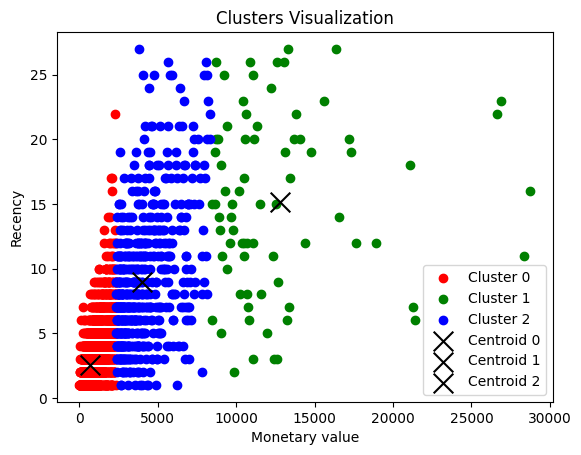

In [ ]:
import matplotlib.pyplot as plt

def visualize_clusters(data_dict, classification, centroids):
    """Visualize clusters and centroids."""
    # Create a color palette for clusters
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for cluster_id, points in classification.items():
        cluster_points = [data_dict[point] for point in points]
        cluster_points = list(zip(*cluster_points))  # Transpose for plotting
        plt.scatter(cluster_points[0], cluster_points[1], c=colors[cluster_id % len(colors)], label=f'Cluster {cluster_id}')

    # Plot centroids
    for cluster_id, centroid in centroids.items():
        if centroid:  # Avoid empty clusters
            plt.scatter(centroid[0], centroid[1], c='k', marker='x', s=200, label=f'Centroid {cluster_id}')

    plt.xlabel('Monetary value')
    plt.ylabel('Recency')
    plt.title('Clusters Visualization')
    plt.legend()
    plt.show()

visualize_clusters(data_dict, classification, centroids)


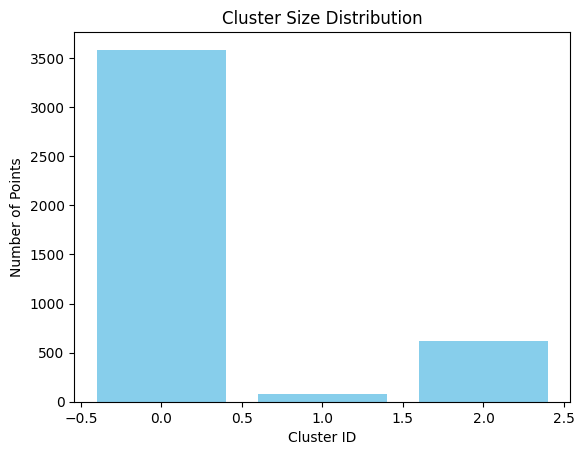

In [ ]:
def visualize_cluster_sizes(classification):
    """Visualize the sizes of each cluster."""
    cluster_sizes = [len(points) for points in classification.values()]
    plt.bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Points')
    plt.title('Cluster Size Distribution')
    plt.show()

visualize_cluster_sizes(classification)

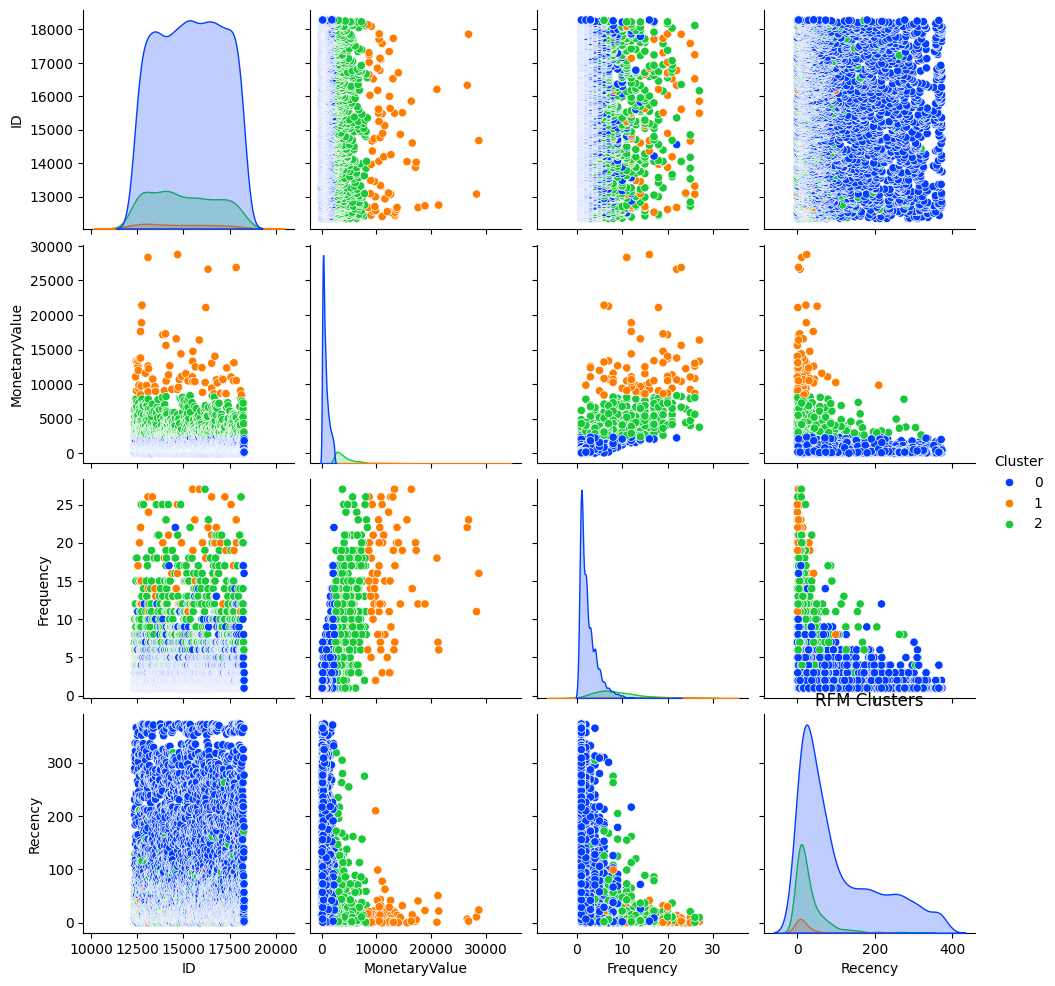

In [ ]:
import seaborn as sns
import pandas as pd

def visualize_rfm_clusters(formatted_data, classification):
    """Visualize RFM clusters using pairwise scatter plots."""
    # Add cluster assignments to the DataFrame
    cluster_assignments = {
        point: cluster for cluster, points in classification.items() for point in points
    }
    formatted_data['Cluster'] = formatted_data['ID'].map(cluster_assignments)

    # Pairplot with seaborn
    sns.pairplot(formatted_data, hue='Cluster', diag_kind='kde', palette='bright')
    plt.title('RFM Clusters')
    plt.show()

# Load processed data
formatted_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Processed_Online_Retail.csv")
visualize_rfm_clusters(formatted_data, classification)

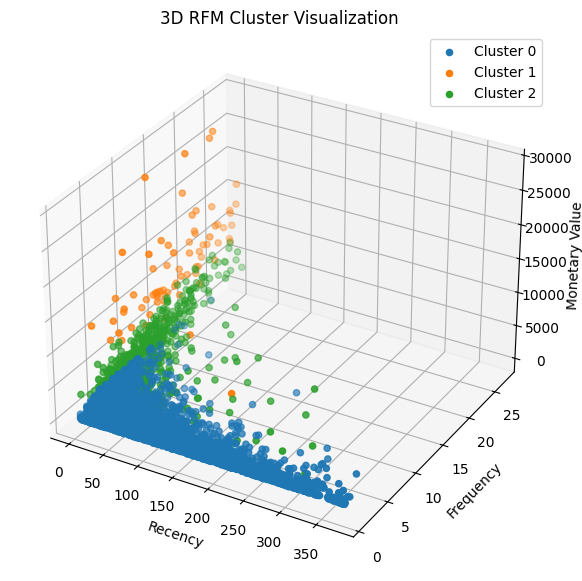

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_rfm(formatted_data, classification):
    """3D scatter plot for RFM data."""
    cluster_assignments = {
        point: cluster for cluster, points in classification.items() for point in points
    }
    formatted_data['Cluster'] = formatted_data['ID'].map(cluster_assignments)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for cluster_id, cluster_data in formatted_data.groupby('Cluster'):
        ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['MonetaryValue'], label=f'Cluster {cluster_id}')

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary Value')
    ax.set_title('3D RFM Cluster Visualization')
    plt.legend()
    plt.show()

visualize_3d_rfm(formatted_data, classification)

In [ ]:
# Main Function for K=5
def process_single_file_k5(file_path, K, output_json, output_csv):
    start_time = time.time()

    # Read the dataset and skip the header
    with open(file_path, 'r') as f:
        next(f)  # Skip the header row
        data_dict = {
            int(float(line.split(',')[0])): list(map(float, line.strip().split(',')[1:]))
            for line in f
        }
    dataset = list(data_dict.keys())

    # Run K-Means for K=5
    classification, centroids = kmeans(dataset, K, data_dict)

    # Save cluster sizes to CSV
    cluster_sizes = [len(points) for points in classification.values()]
    with open(output_csv, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(['Cluster', 'Size'])
        for cluster_id, size in enumerate(cluster_sizes):
            csvwriter.writerow([cluster_id, size])

    # Save cluster assignments to JSON
    with open(output_json, 'w') as json_file:
        json.dump({point: cluster for cluster, points in classification.items() for point in points}, json_file)

    print(f"K=5 Clustering completed in {time.time() - start_time:.2f} seconds.")
    print(f"Cluster sizes: {cluster_sizes}")

    # Return variables for visualization
    return data_dict, classification, centroids


Converged after 54 iterations.
K=5 Clustering completed in 2.07 seconds.
Cluster sizes: [899, 81, 13, 2962, 320]
Visualizing Results for K=5:


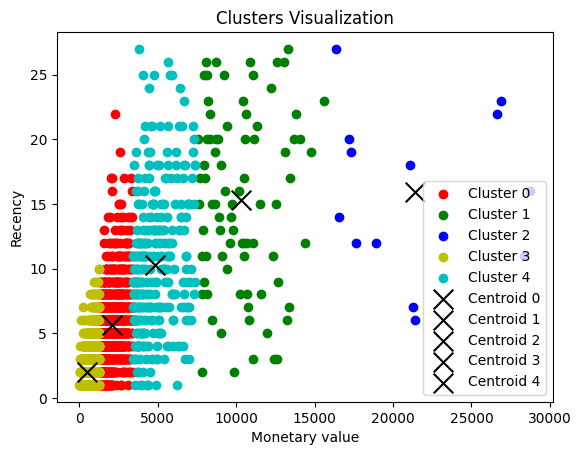

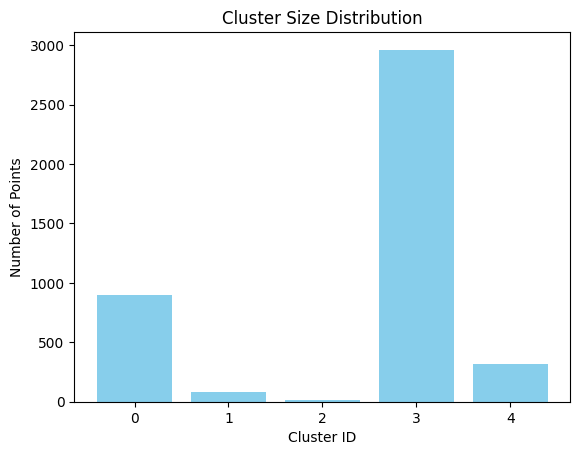

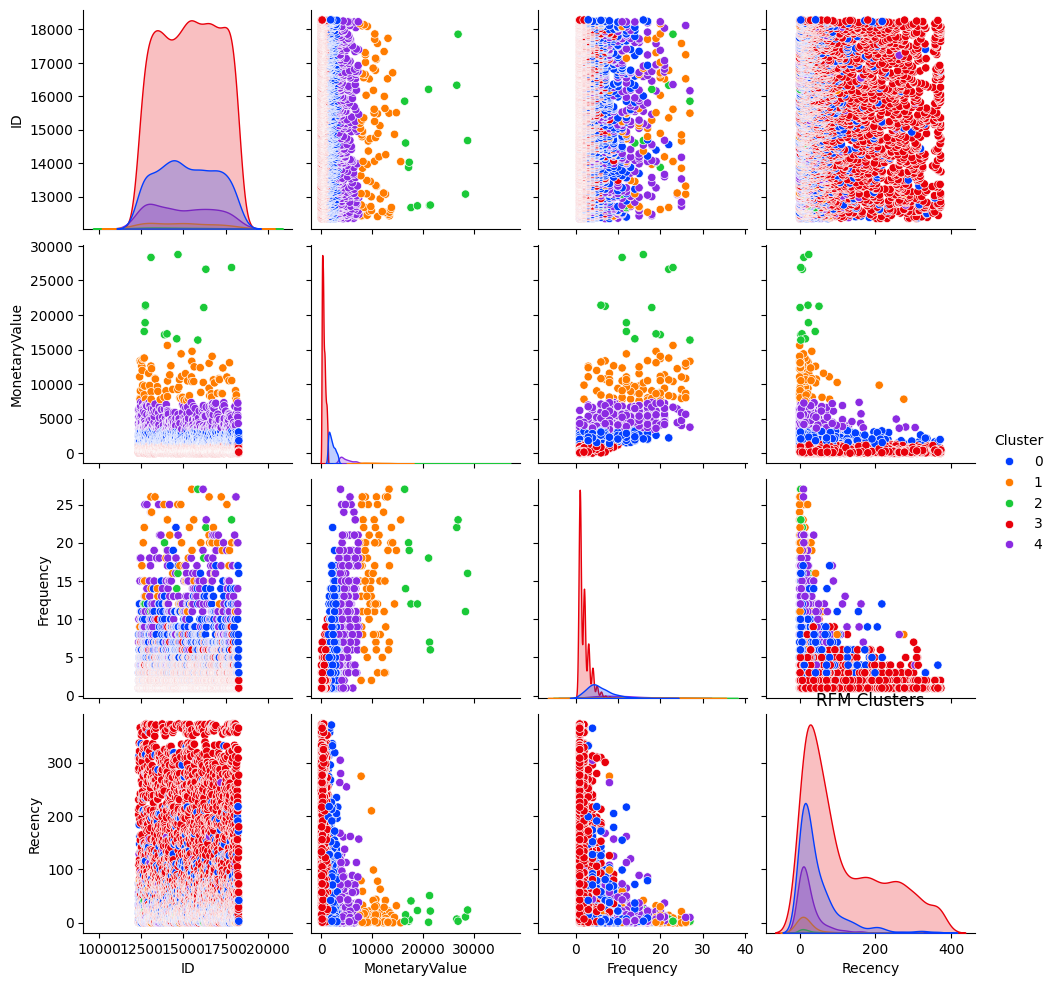

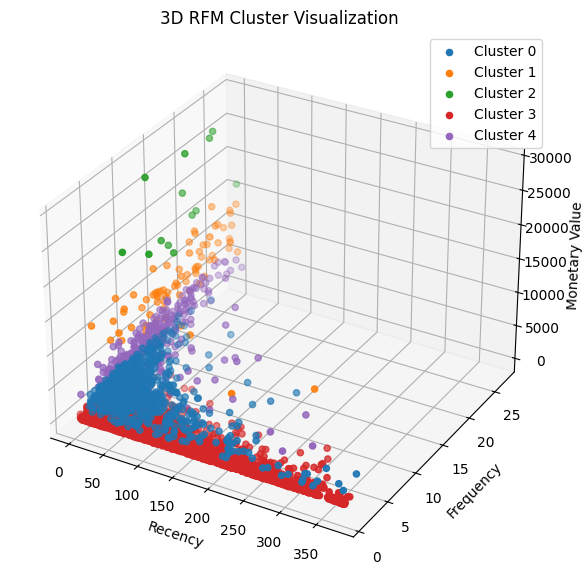

In [ ]:
# File paths and parameters for K=5
file_path = "/content/drive/My Drive/Colab Notebooks/Processed_Online_Retail.csv"
K = 5  # Number of clusters for this block
output_json_k5 = "/content/drive/My Drive/Colab Notebooks/output_k5.json"
output_csv_k5 = "/content/drive/My Drive/Colab Notebooks/output_k5.csv"

# Run clustering for K=5
data_dict_k5, classification_k5, centroids_k5 = process_single_file_k5(file_path, K, output_json_k5, output_csv_k5)

# Visualize results for K=5
print("Visualizing Results for K=5:")
visualize_clusters(data_dict_k5, classification_k5, centroids_k5)
visualize_cluster_sizes(classification_k5)
visualize_rfm_clusters(formatted_data, classification_k5)
visualize_3d_rfm(formatted_data, classification_k5)
